# IMPORT LIBRARY

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    make_scorer,
    recall_score,
    precision_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# LOAD DATA & DATA CLEANING

In [87]:
df = pd.read_csv("predictive_maintenance.csv")

# Drop unnecessary columns
drop_cols = ["UDI", "Product ID"]
df = df.drop(columns=drop_cols, errors="ignore")

# Rename columns
df = df.rename(
    columns={
        "Air temperature [K]": "air_temp",
        "Process temperature [K]": "process_temp",
        "Rotational speed [rpm]": "rpm",
        "Torque [Nm]": "torque",
        "Tool wear [min]": "tool_wear",
        "Failure Type": "failure",
    }
)

df = df.drop_duplicates()

# Convert to numeric
num_cols = ["air_temp", "process_temp", "rpm", "torque", "tool_wear"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(f"Dataset shape: {df.shape}")
print(f"Failure distribution:\n{df['Target'].value_counts()}")

Dataset shape: (10000, 8)
Failure distribution:
Target
0    9661
1     339
Name: count, dtype: int64


# FEATURE ENGINEERING


In [88]:
df["temp_diff"] = df["process_temp"] - df["air_temp"]
df["torque_rpm_ratio"] = df["torque"] / (df["rpm"] + 1e-5)
df["power"] = df["torque"] * df["rpm"] / 9.5488
df["temp_stress"] = df["process_temp"] / (df["air_temp"] + 1e-5)
df["wear_per_rpm"] = df["tool_wear"] / (df["rpm"] + 1e-5)
df["torque_squared"] = df["torque"] ** 2
df["tool_wear_squared"] = df["tool_wear"] ** 2
df["torque_wear_interaction"] = df["torque"] * df["tool_wear"]
df["rpm_temp_interaction"] = df["rpm"] * df["temp_diff"]
df["power_wear_ratio"] = df["power"] / (df["tool_wear"] + 1e-5)

print(f"Total features after engineering: {len(df.columns) - 2}")

Total features after engineering: 16


# PREPROCESSING

In [89]:
type_le = LabelEncoder()
df["Type"] = type_le.fit_transform(df["Type"])

# Anomaly detection :
# - Normal data = No Failure (Target = 0)
# - Anomaly = Any Failure (Target = 1)

X = df.drop(columns=["Target", "failure"])
y = df["Target"]  # 0 = normal, 1 = anomaly

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Untuk training anomaly detection hanya gunakan data normal
X_train_normal = X_train[y_train == 0]
X_test_full = X_test  # Test dengan semua data (normal + anomaly)
y_test_full = y_test

print(f"\nTraining samples (normal only): {len(X_train_normal)}")
print(f"Test samples (normal + anomaly): {len(X_test_full)}")
print(f"Test anomaly ratio: {y_test_full.sum() / len(y_test_full):.2%}")

# Scale features
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test_full)


Training samples (normal only): 7729
Test samples (normal + anomaly): 2000
Test anomaly ratio: 3.40%


# MODELING

In [ ]:
# Parameter grid
nu_values = [0.02, 0.03, 0.034, 0.04, 0.05, 0.06, 0.07, 0.08]
gamma_values = ['scale', 'auto', 0.001, 0.01, 0.1, 1.0]

results = []
best_f1 = 0
best_model = None
best_params = None

for nu in nu_values:
    for gamma in gamma_values:
        # Train model
        ocsvm = OneClassSVM(
            kernel='rbf',
            gamma=gamma,
            nu=nu
        )
        
        ocsvm.fit(X_train_normal_scaled)
        
        # Predict
        y_pred = ocsvm.predict(X_test_scaled)
        y_pred = np.where(y_pred == -1, 1, 0)  # Convert to 0/1
        
        # Calculate metrics
        recall = recall_score(y_test_full, y_pred)
        precision = precision_score(y_test_full, y_pred, zero_division=0)
        f1 = f1_score(y_test_full, y_pred, zero_division=0)
        
        # Store results
        result = {
            'nu': nu,
            'gamma': str(gamma),
            'recall': recall,
            'precision': precision,
            'f1': f1
        }
        results.append(result)

        print(f"nu={nu:.3f}, gamma={str(gamma):>6s} | Recall: {recall:.3f}, Precision: {precision:.3f}, F1: {f1:.3f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_model = ocsvm
            best_params = result.copy()

nu=0.020, gamma= scale | Recall: 0.338, Precision: 0.311, F1: 0.324
nu=0.020, gamma=  auto | Recall: 0.338, Precision: 0.311, F1: 0.324
nu=0.020, gamma= 0.001 | Recall: 0.426, Precision: 0.453, F1: 0.439
nu=0.020, gamma=  0.01 | Recall: 0.412, Precision: 0.394, F1: 0.403
nu=0.020, gamma=   0.1 | Recall: 0.353, Precision: 0.276, F1: 0.310
nu=0.020, gamma=   1.0 | Recall: 0.956, Precision: 0.062, F1: 0.117
nu=0.030, gamma= scale | Recall: 0.382, Precision: 0.286, F1: 0.327
nu=0.030, gamma=  auto | Recall: 0.382, Precision: 0.286, F1: 0.327
nu=0.030, gamma= 0.001 | Recall: 0.515, Precision: 0.407, F1: 0.455
nu=0.030, gamma=  0.01 | Recall: 0.471, Precision: 0.376, F1: 0.418
nu=0.030, gamma=   0.1 | Recall: 0.412, Precision: 0.277, F1: 0.331
nu=0.030, gamma=   1.0 | Recall: 0.956, Precision: 0.062, F1: 0.116
nu=0.034, gamma= scale | Recall: 0.382, Precision: 0.257, F1: 0.308
nu=0.034, gamma=  auto | Recall: 0.382, Precision: 0.257, F1: 0.308
nu=0.034, gamma= 0.001 | Recall: 0.515, Precisio


--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.98      0.97      0.98      1932
     Anomaly       0.41      0.51      0.45        68

    accuracy                           0.96      2000
   macro avg       0.69      0.74      0.72      2000
weighted avg       0.96      0.96      0.96      2000



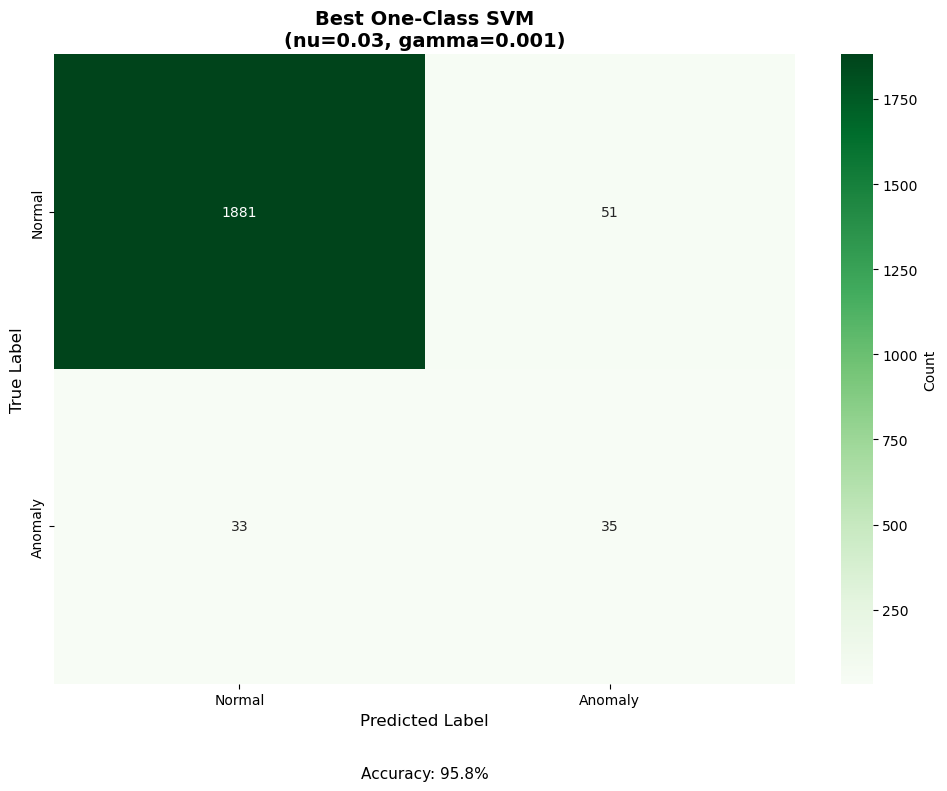

In [91]:
y_pred_best = best_model.predict(X_test_scaled)
y_pred_best = np.where(y_pred_best == -1, 1, 0)

print("\n--- Classification Report ---")
print(classification_report(y_test_full, y_pred_best,
                           target_names=['Normal', 'Anomaly'],
                           zero_division=0))

cm = confusion_matrix(y_test_full, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            cbar_kws={'label': 'Count'})
plt.title(f'Best One-Class SVM\n(nu={best_params["nu"]}, gamma={best_params["gamma"]})', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
plt.text(0.5, -0.15, f'Accuracy: {accuracy:.1%}', 
         ha='center', transform=plt.gca().transAxes, fontsize=11)

plt.tight_layout()
plt.show()

# EXPORT MODEL

In [92]:
joblib.dump(ocsvm, 'model_anomaly/anomaly_ocsvm.pkl')
joblib.dump(scaler, 'model_anomaly/anomaly_scaler.pkl')
joblib.dump(type_le, 'model_anomaly/anomaly_type_le.pkl')

['model_anomaly/anomaly_type_le.pkl']

# TESTING

In [93]:
ocsvm = joblib.load('model_anomaly/anomaly_ocsvm.pkl')
scaler = joblib.load('model_anomaly/anomaly_scaler.pkl')
type_le = joblib.load('model_anomaly/anomaly_type_le.pkl')

In [ ]:
def detect_anomaly(sensor_data, use_threshold=False, custom_threshold=None):
    """
    Detect anomaly from sensor readings
    
    Parameters:
    -----------
    sensor_data : dict
        Dictionary with keys:
        - Type: str ('L', 'M', or 'H')
        - air_temp: float (Kelvin)
        - process_temp: float (Kelvin)
        - rpm: int (rotational speed)
        - torque: float (Nm)
        - tool_wear: int (minutes)
    
    use_threshold : bool
        If True, use custom threshold instead of default decision
    
    custom_threshold : float
        Custom threshold for decision function (if use_threshold=True)
    
    Returns:
    --------
    result : dict
        Detection results with anomaly score and recommendation
    """
    
    # Create DataFrame
    df_input = pd.DataFrame([sensor_data])
    
    # Encode Type
    df_input['Type'] = type_le.transform(df_input['Type'])
    
    # Feature engineering (MUST match training!)
    df_input['temp_diff'] = df_input['process_temp'] - df_input['air_temp']
    df_input['torque_rpm_ratio'] = df_input['torque'] / (df_input['rpm'] + 1e-5)
    df_input['power'] = df_input['torque'] * df_input['rpm'] / 9.5488
    df_input['temp_stress'] = df_input['process_temp'] / (df_input['air_temp'] + 1e-5)
    df_input['wear_per_rpm'] = df_input['tool_wear'] / (df_input['rpm'] + 1e-5)
    df_input['torque_squared'] = df_input['torque'] ** 2
    df_input['tool_wear_squared'] = df_input['tool_wear'] ** 2
    df_input['torque_wear_interaction'] = df_input['torque'] * df_input['tool_wear']
    df_input['rpm_temp_interaction'] = df_input['rpm'] * df_input['temp_diff']
    df_input['power_wear_ratio'] = df_input['power'] / (df_input['tool_wear'] + 1e-5)
    
    # Scale features
    X_scaled = scaler.transform(df_input)
    
    # Get decision function score (lower = more anomalous)
    decision_score = ocsvm.decision_function(X_scaled)[0]
    
    # Predict anomaly
    if use_threshold and custom_threshold is not None:
        # Use custom threshold
        is_anomaly = decision_score < custom_threshold
        prediction_method = f"Custom Threshold ({custom_threshold:.4f})"
    else:
        # Use model's default decision
        prediction = ocsvm.predict(X_scaled)[0]
        is_anomaly = (prediction == -1)
        prediction_method = "Default SVM Decision"
    
    confidence = 1 / (1 + np.exp(decision_score))  # Sigmoid normalization
    
    # Generate recommendation
    recommendation = get_recommendation(
        is_anomaly=is_anomaly,
        decision_score=decision_score,
        sensor_data=sensor_data,
        confidence=confidence
    )
    
    # Prepare result
    result = {
        'is_anomaly': bool(is_anomaly),
        'decision_score': float(decision_score),
        'confidence': float(confidence),
        'prediction_method': prediction_method,
        'recommendation': recommendation,
        'sensor_data': sensor_data,
        'engineered_features': {
            'temp_diff': float(df_input['temp_diff'].iloc[0]),
            'power': float(df_input['power'].iloc[0]),
            'temp_stress': float(df_input['temp_stress'].iloc[0]),
        }
    }
    
    return result


def get_recommendation(is_anomaly, decision_score, sensor_data, confidence):
    """
    Generate maintenance recommendation based on anomaly detection
    """
    
    if not is_anomaly:
        return {
            'status': 'NORMAL',
            'action': 'Continue normal operation',
            'priority': 'LOW',
            'message': 'All sensor readings are within normal parameters.',
            'next_inspection': 'Routine maintenance as scheduled'
        }
    
    # Analyze which parameters might be problematic
    issues = []
    
    # Check temperature
    temp_diff = sensor_data['process_temp'] - sensor_data['air_temp']
    if temp_diff > 10:
        issues.append(f'High temperature differential ({temp_diff:.1f}K)')
    if temp_diff < 8:
        issues.append(f'Low temperature differential ({temp_diff:.1f}K)')
    
    # Check RPM
    if sensor_data['rpm'] < 1200:
        issues.append(f'Low RPM ({sensor_data["rpm"]})')
    elif sensor_data['rpm'] > 2800:
        issues.append(f'High RPM ({sensor_data["rpm"]})')
    
    # Check torque
    if sensor_data['torque'] > 70:
        issues.append(f'High torque ({sensor_data["torque"]:.1f} Nm)')
    elif sensor_data['torque'] < 20:
        issues.append(f'Low torque ({sensor_data["torque"]:.1f} Nm)')
    
    # Check tool wear
    if sensor_data['tool_wear'] > 200:
        issues.append(f'Excessive tool wear ({sensor_data["tool_wear"]} min)')
    
    # Check temperature levels
    if sensor_data['air_temp'] > 305:
        issues.append(f'High air temperature ({sensor_data["air_temp"]:.1f}K)')
    if sensor_data['process_temp'] > 315:
        issues.append(f'High process temperature ({sensor_data["process_temp"]:.1f}K)')
    
    # Determine priority based on severity
    if decision_score < -0.5:
        priority = 'CRITICAL'
        timeframe = 'Immediate (within 4 hours)'
    elif decision_score < -0.2:
        priority = 'HIGH'
        timeframe = 'Urgent (within 24 hours)'
    elif decision_score < 0:
        priority = 'MEDIUM'
        timeframe = 'Soon (within 72 hours)'
    else:
        priority = 'LOW'
        timeframe = 'Next scheduled maintenance'
    
    return {
        'status': 'ANOMALY DETECTED',
        'action': 'Schedule equipment inspection',
        'priority': priority,
        'severity_score': float(decision_score),
        'confidence': float(confidence),
        'issues_detected': issues if issues else ['General anomaly pattern detected'],
        'message': f"Anomaly detected with {len(issues)} potential issue(s). Confidence: {confidence:.1%}",
        'next_inspection': timeframe
    }

In [95]:
print("TEST CASE 1: NORMAL OPERATION")

normal_case = {
    'Type': 'M',
    'air_temp': 298.1,
    'process_temp': 308.6,
    'rpm': 1551,
    'torque': 42.8,
    'tool_wear': 0
}

print(f"\n📊 Input Data:")
for key, value in normal_case.items():
    print(f"   {key}: {value}")

result = detect_anomaly(normal_case)

print(f"\n🎯 Detection Result:")
print(f"   Status: {'⚠️ ANOMALY' if result['is_anomaly'] else '✅ NORMAL'}")
print(f"   Decision Score: {result['decision_score']:.4f}")
print(f"   Confidence: {result['confidence']:.1%}")
print(f"   Method: {result['prediction_method']}")

print(f"\n📋 Recommendation:")
rec = result['recommendation']
print(f"   Status: {rec['status']}")
print(f"   Action: {rec['action']}")
print(f"   Priority: {rec['priority']}")
print(f"   Message: {rec['message']}")

TEST CASE 1: NORMAL OPERATION

📊 Input Data:
   Type: M
   air_temp: 298.1
   process_temp: 308.6
   rpm: 1551
   torque: 42.8
   tool_wear: 0

🎯 Detection Result:
   Status: ✅ NORMAL
   Decision Score: 0.0004
   Confidence: 50.0%
   Method: Default SVM Decision

📋 Recommendation:
   Status: NORMAL
   Action: Continue normal operation
   Priority: LOW
   Message: All sensor readings are within normal parameters.


In [96]:
print("TEST CASE 2: HIGH TEMPERATURE ANOMALY")

high_temp_case = {
    'Type': 'H',
    'air_temp': 304.5,
    'process_temp': 313.8,
    'rpm': 1380,
    'torque': 52.0,
    'tool_wear': 108
}

print(f"\n📊 Input Data:")
for key, value in high_temp_case.items():
    print(f"   {key}: {value}")

result = detect_anomaly(high_temp_case)

print(f"\n🎯 Detection Result:")
print(f"   Status: {'⚠️ ANOMALY' if result['is_anomaly'] else '✅ NORMAL'}")
print(f"   Decision Score: {result['decision_score']:.4f}")
print(f"   Confidence: {result['confidence']:.1%}")

print(f"\n📋 Recommendation:")
rec = result['recommendation']
print(f"   Status: {rec['status']}")
print(f"   Priority: {rec['priority']}")
print(f"   Severity Score: {rec['severity_score']:.4f}")
print(f"   Issues Detected:")
for issue in rec['issues_detected']:
    print(f"      - {issue}")
print(f"   Next Inspection: {rec['next_inspection']}")

TEST CASE 2: HIGH TEMPERATURE ANOMALY

📊 Input Data:
   Type: H
   air_temp: 304.5
   process_temp: 313.8
   rpm: 1380
   torque: 52.0
   tool_wear: 108

🎯 Detection Result:
   Status: ⚠️ ANOMALY
   Decision Score: -0.2827
   Confidence: 57.0%

📋 Recommendation:
   Status: ANOMALY DETECTED
   Priority: HIGH
   Severity Score: -0.2827
   Issues Detected:
      - General anomaly pattern detected
   Next Inspection: Urgent (within 24 hours)


In [97]:
print("TEST CASE 3: EXTREME VALUES (CRITICAL)")

extreme_case = {
    'Type': 'L',
    'air_temp': 310.0,
    'process_temp': 320.0,
    'rpm': 900,
    'torque': 80.0,
    'tool_wear': 250
}

print(f"\n📊 Input Data:")
for key, value in extreme_case.items():
    print(f"   {key}: {value}")

result = detect_anomaly(extreme_case)

print(f"\n🎯 Detection Result:")
print(f"   Status: {'⚠️ ANOMALY' if result['is_anomaly'] else '✅ NORMAL'}")
print(f"   Decision Score: {result['decision_score']:.4f}")
print(f"   Confidence: {result['confidence']:.1%}")

print(f"\n📋 Recommendation:")
rec = result['recommendation']
print(f"   Status: {rec['status']}")
print(f"   Priority: {rec['priority']} ⚠️")
print(f"   Issues Detected:")
for issue in rec['issues_detected']:
    print(f"      - {issue}")

TEST CASE 3: EXTREME VALUES (CRITICAL)

📊 Input Data:
   Type: L
   air_temp: 310.0
   process_temp: 320.0
   rpm: 900
   torque: 80.0
   tool_wear: 250

🎯 Detection Result:
   Status: ⚠️ ANOMALY
   Decision Score: -0.5363
   Confidence: 63.1%

📋 Recommendation:
   Status: ANOMALY DETECTED
   Priority: CRITICAL ⚠️
   Issues Detected:
      - Low RPM (900)
      - High torque (80.0 Nm)
      - Excessive tool wear (250 min)
      - High air temperature (310.0K)
      - High process temperature (320.0K)


In [98]:
print("TEST CASE 4: LOW RPM ANOMALY")

low_rpm_case = {
    'Type': 'M',
    'air_temp': 299.0,
    'process_temp': 309.0,
    'rpm': 1100,  # Very low
    'torque': 65.0,  # High torque at low RPM
    'tool_wear': 150
}

print(f"\n📊 Input Data:")
for key, value in low_rpm_case.items():
    print(f"   {key}: {value}")

result = detect_anomaly(low_rpm_case)

print(f"\n🎯 Detection Result:")
print(f"   Status: {'⚠️ ANOMALY' if result['is_anomaly'] else '✅ NORMAL'}")
print(f"   Decision Score: {result['decision_score']:.4f}")
print(f"   Confidence: {result['confidence']:.1%}")

print(f"\n📋 Recommendation:")
rec = result['recommendation']
print(f"   Status: {rec['status']}")
print(f"   Priority: {rec['priority']}")
print(f"   Issues: {', '.join(rec['issues_detected'])}")

TEST CASE 4: LOW RPM ANOMALY

📊 Input Data:
   Type: M
   air_temp: 299.0
   process_temp: 309.0
   rpm: 1100
   torque: 65.0
   tool_wear: 150

🎯 Detection Result:
   Status: ⚠️ ANOMALY
   Decision Score: -0.4992
   Confidence: 62.2%

📋 Recommendation:
   Status: ANOMALY DETECTED
   Priority: HIGH
   Issues: Low RPM (1100)
